<a href="https://colab.research.google.com/github/CryptoRobotFr/General-code-trading-bot/blob/main/Support_Resistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install python-binance mplfinance 

     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 70 kB 8.4 MB/s 
     |████████████████████████████████| 288 kB 59.3 MB/s 
     |████████████████████████████████| 103 kB 52.1 MB/s 
     |████████████████████████████████| 1.1 MB 64.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 144 kB 52.1 MB/s 
     |████████████████████████████████| 271 kB 49.0 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 


In [3]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from binance.client import Client
from statistics import mean

# plt.rcParams['figure.figsize'] = [12, 7]
# plt.rc('font', size=14) 

In [24]:
def get_data_from_api(
    pair_symbol,
    startDate = "1 january 2021"
):
    # -- Define Binance Client --
    client = Client()

    timeInterval = Client.KLINE_INTERVAL_1DAY

    # -- Load all price data from binance API --
    klinesT = client.get_historical_klines(pair_symbol, timeInterval, startDate)

    # -- Define your dataset --
    df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    df['close'] = pd.to_numeric(df['close'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['open'] = pd.to_numeric(df['open'])

    # -- Set the date to index --
    df = df.set_index(df['timestamp'])
    df.index = pd.to_datetime(df.index, unit='ms')
    del df['timestamp']

    # -- Drop all columns we do not need --
    df = df.loc[:,['open', 'high', 'low', 'close']]

    return df

def get_n_columns(df, columns, n=1):
    dt = df.copy()
    for col in columns:
        dt["n"+str(n)+"_"+col] = dt[col].shift(n)
    return dt

def get_top_and_bottom(df, candle_min_window=3):
    originals_columns = list(df.columns.copy())
    originals_columns.append("top")
    originals_columns.append("bottom")
    dt = df.copy()
    dt["bottom"] = 1
    dt["top"] = 1

    for i in range(1, candle_min_window + 1, 1):
        dt = get_n_columns(dt, ['close'], i)
        dt = get_n_columns(dt, ['close'], -i)

        dt.loc[
            (dt["n" + str(-i) + "_close"] < dt["close"]) 
            | (dt["n" + str(i) + "_close"] < dt["close"])
            , "bottom"
        ] = 0

        dt.loc[
            (dt["n" + str(-i) + "_close"] > dt["close"]) 
            | (dt["n" + str(i) + "_close"] > dt["close"])
            , "top"
        ] = 0
    # print(dt)
    dt = dt.loc[:,originals_columns]

    return dt

def group_level(df, group_multiplier = 1):
    df_test = df.copy()
    d = list(df_test.loc[df_test["bottom"]==1, "close"])
    d.extend(list(df_test.loc[df_test["top"]==1, "close"]))

    d.sort()

    diff = [y - x for x, y in zip(*[iter(d)] * 2)]
    avg = sum(diff) / len(diff)

    important_levels = [[d[0]]]

    for x in d[1:]:
        if x - important_levels[-1][0] < group_multiplier * avg:
            important_levels[-1].append(x)
        else:
            important_levels.append([x])

    return important_levels

def plot_level(
    pair_symbol = "BTCUSDT", 
    startDate = "1 january 2021", 
    top_bottom_window = 3, 
    group_multiplier = 1, 
    min_group_number = 2,
    show_tv_code = False
):
    df = get_data_from_api(pair_symbol, startDate)
    df = get_top_and_bottom(df, top_bottom_window)
    levels = group_level(df, group_multiplier)
    
    tv_paste_text = ""

    df["iloc_val"] = list(range(0,len(df),1))
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 6})

    fig1 = mpf.figure(1, figsize=(20, 7), style=s) 
    fig2 = mpf.figure(2, figsize=(20, 7), style=s) 
    ax1 = fig1.add_subplot(111)
    ax2 = fig2.add_subplot(111)


    mpf.plot(df, type='candle', ax=ax1)
    mpf.plot(df, type='candle', ax=ax2)

    plt.figure(1)
    if levels:
        for i in range(len(levels)):
            if len(levels[i]) >= min_group_number:
                plt.hlines(mean(levels[i]), xmin=0, xmax=len(df), colors='blue', lw=len(levels[i]) - (min_group_number - 1))
                tv_paste_text += "\narray.push(levels, " + str(mean(levels[i])) + ")\narray.push(level_width, " + str(len(levels[i]) - (min_group_number - 1)) + ")"

    plt.figure(2)
    for index, row in df.loc[df["top"]==1].iterrows():
        plt.hlines(row["close"],xmin=row["iloc_val"], xmax=len(df), colors='indianred', lw=1)

    for index, row in df.loc[df["bottom"]==1].iterrows():
        plt.hlines(row["close"],xmin=row["iloc_val"], xmax=len(df), colors='purple', lw=1)

    if show_tv_code:
        print(tv_paste_text)


In [ ]:
df = get_data_from_api("BTCUSDT", "1 january 2021")
df = get_top_and_bottom(df, 10)
levels = group_level(df, 1)
# df
levels


array.push(levels, 30084.58)
array.push(level_width, 2)
array.push(levels, 34190.288)
array.push(level_width, 3)
array.push(levels, 40064.436)
array.push(level_width, 3)
array.push(levels, 41713.262500000004)
array.push(level_width, 2)
array.push(levels, 44561.362)
array.push(level_width, 3)
array.push(levels, 48386.503333333334)
array.push(level_width, 1)
array.push(levels, 58121.1075)
array.push(level_width, 2)


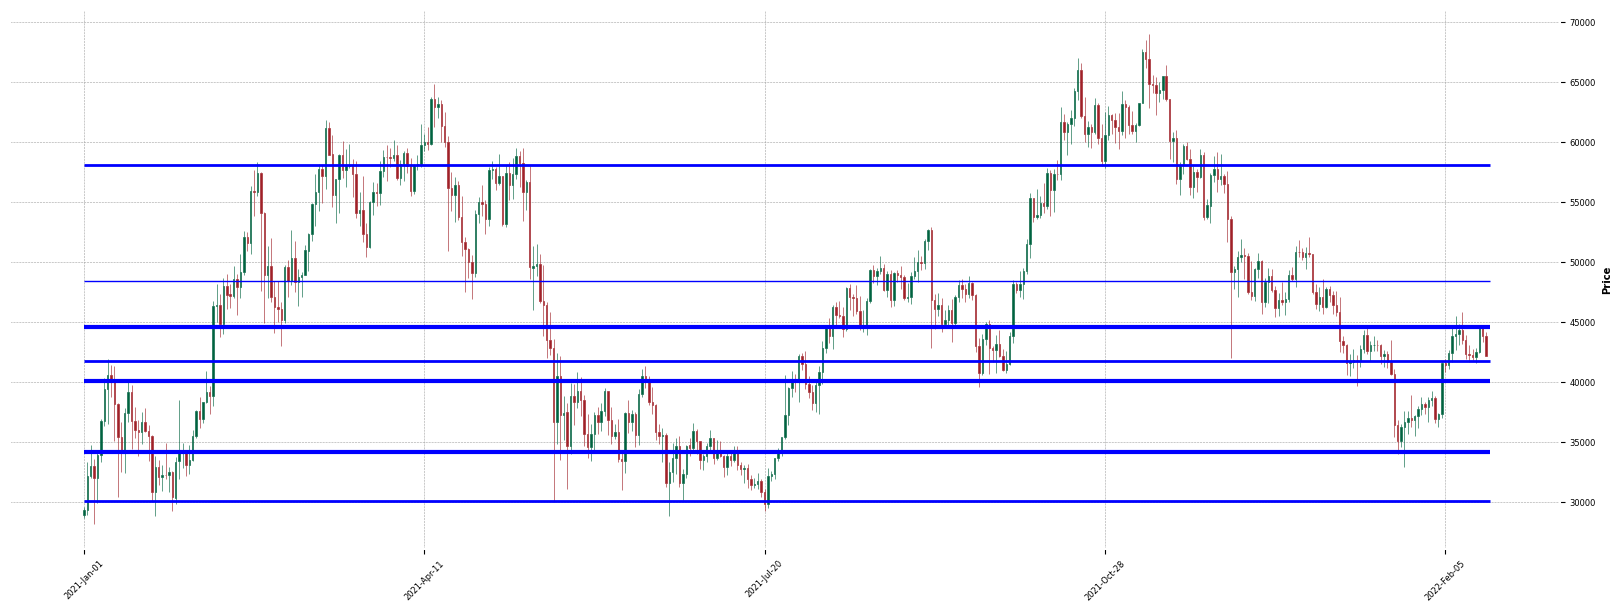

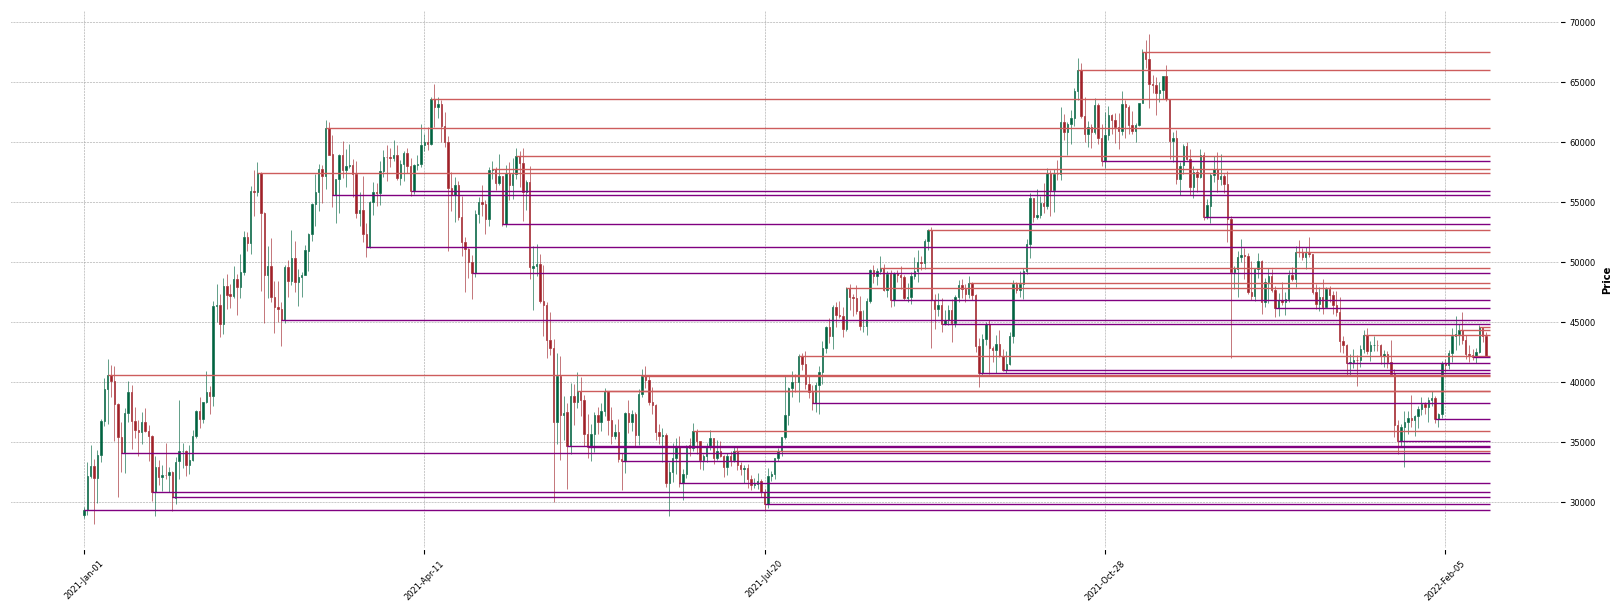

In [42]:
plot_level(
    pair_symbol = "BTCUSDT", 
    startDate = "1 january 2021", 
    top_bottom_window = 5, 
    group_multiplier = 2, 
    min_group_number = 3,
    show_tv_code = True
)